In [ ]:
''' 
1.Read data (protein ps region/ps protein nonps region/nops protein nops region)
2.validation using models that exclude uids
'''
import pandas as pd 
import requests
from tqdm import tqdm
from Bio import SeqIO
import numpy as np
from tools_nn_related import * 
from tools import *
pth = 'data_source/truncated_regions/13059_2023_3128_MOESM5_ESM.xlsx'
psp = pd.read_excel(
    pth,skiprows=1,sheet_name='PS-protein-PS-regions')
psp_pscores = psp['PScore'].values 
psp_plaacs = psp['PLAAC'].values 
psnop = pd.read_excel(
    pth,skiprows=1,sheet_name='PS-protein-nonPS-regions')
psnop_pscores = psnop['PScore'].values 
psnop_plaacs = psnop['PLAAC'].values 

nopsnop = pd.read_excel(
    pth,skiprows=1,sheet_name='nonPS-protein-nonPS-regions')
nopsnop_pscores = nopsnop['PScore'].values 
nopsnop_plaacs = nopsnop['PLAAC'].values 

pscores_all = list(psp_pscores)+list(psnop_pscores)+\
    list(nopsnop_pscores)
plaacs_all = list(psp_plaacs)+list(psnop_plaacs)+\
    list(nopsnop_plaacs)
labels_all = [1]*len(psp_pscores)+[0]*(len(nopsnop_pscores)+len(psnop_pscores))
# uniprot_seq_all_file = 'data_source/data_collection/uniprot_sprot.fasta'
# gene_name2uniprot_entry = {}
# gene_name2seq = {}
# uniprot_id2seq = {}
# uidall = []
# for record in SeqIO.parse(uniprot_seq_all_file,'fasta'):
#     try:
#         gene_name = record.description.split('GN=')[1].split(' ')[0]
#         uniprot_entry = record.id.split('|')[-1]
#         uniprot_id = record.id.split('|')[1]
#         gene_name2uniprot_entry[gene_name] = uniprot_entry
#         gene_name2seq[gene_name] = str(record.seq)
#         uniprot_id2seq[uniprot_id] = str(record.seq)
#         uidall.append(uniprot_id)
#     except:
#         pass
    
# uidall = set(uidall)
# print(len(uidall))
# def pred_seqs(seq_lst):
#     seq_matrix_lst = seq2matrix_lst(seq_lst)
#     saps_py_lst,pdps_py_lst,\
#     mix_py_lst = [],[],[]
#     for matrix_ in tqdm(seq_matrix_lst):
#         p = saps_kernel(matrix_,)
#         saps_py_lst.append(p)
#         p = pdps_kernel(matrix_,)
#         pdps_py_lst.append(p)
#         p = mix_kernel(matrix_,)
#         mix_py_lst.append(p) # 18781nops 444ps
#     return saps_py_lst,pdps_py_lst,mix_py_lst

# def pred_seqs_scan(seq_lst):
#     seq_matrix_lst = seq2matrix_lst(seq_lst)
#     saps_py_lst,pdps_py_lst,\
#     mix_py_lst = [],[],[]
#     for matrix_ in tqdm(seq_matrix_lst):
#         _,p = predict_by_saps_models(matrix_,)
#         saps_py_lst.append(p)
#         _,p = predict_by_pdps_models(matrix_,)
#         pdps_py_lst.append(p)
#         _,p = predict_by_mix_models(matrix_,)
#         mix_py_lst.append(p)
#     return saps_py_lst,pdps_py_lst,mix_py_lst

# uids_trunc = []
# psp_seqs = []
# for uid,region_str in zip(psp['Protein'].values,psp['Region'].values):
#     seq = uniprot_id2seq[uid]
    
#     region_start,region_end = int(region_str.split('_')[0]),\
#         int(region_str.split('_')[1])
#     trunc_seq = seq[region_start-1:region_end-1]
#     psp_seqs.append(trunc_seq)
#     uids_trunc.append(uid)
# psnop_seqs = []
# for uid,region_str in zip(psnop['Protein'].values,psnop['Region'].values):
#     seq = uniprot_id2seq[uid]
    
#     region_start,region_end = int(region_str.split('_')[0]),\
#         int(region_str.split('_')[1])
#     trunc_seq = seq[region_start-1:region_end-1]
#     psnop_seqs.append(trunc_seq)
#     uids_trunc.append(uid)
# nopspnop_seqs = []
# for uid,region_str in zip(nopsnop['Protein'].values,nopsnop['Region'].values):
#     seq = uniprot_id2seq[uid]
#     region_start,region_end = int(region_str.split('_')[0]),\
#         int(region_str.split('_')[1])
#     trunc_seq = seq[region_start-1:region_end-1]
#     nopspnop_seqs.append(trunc_seq)
#     uids_trunc.append(uid)
# print(len(psp_seqs),len(psnop_seqs),len(nopspnop_seqs))
# print(len(set(uids_trunc)))


loading or downloading model


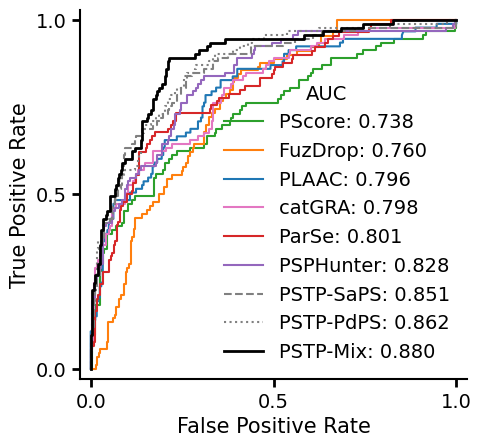

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,average_precision_score,precision_recall_curve
from sklearn.metrics import auc,roc_auc_score
def compute_prec_reca(label,predict):
    prec,reca,_ = precision_recall_curve(label, predict)
    aupr_score = auc(reca,prec) 
    aupr = average_precision_score(label,predict) 
    return prec,reca,aupr_score

def compute_fpr_tpr(label,predict):
    fpr,tpr,_ = roc_curve(label, predict)
    return fpr,tpr,roc_auc_score(label,predict)


ty = np.load('data_processed/results/truncated_proteins/ty.npy')
scan_mix_py = np.load('data_processed/results/truncated_proteins/pstp/scan_mix_py.npy') # kernel 
scan_saps_py = np.load('data_processed/results/truncated_proteins/pstp/scan_saps_py.npy') # kernel 
scan_pdps_py = np.load('data_processed/results/truncated_proteins/pstp/scan_pdps_py.npy') # kernel 
scanall_mix_py = np.load('data_processed/results/truncated_proteins/pstp_scan/scan_mix_py.npy') # scan
scanall_saps_py = np.load('data_processed/results/truncated_proteins/pstp_scan/scan_saps_py.npy')
scanall_pdps_py = np.load('data_processed/results/truncated_proteins/pstp_scan/scan_pdps_py.npy')
plaac_py = np.load('data_processed/results/truncated_proteins/plaac_py.npy')
pscore_py = np.load('data_processed/results/truncated_proteins/pscore_py.npy')
parse_py = np.load('data_processed/results/truncated_proteins/parse_py.npy')
parse_ty = np.load('data_processed/results/truncated_proteins/parse_ty.npy')
fuzdrop_py = np.load('data_processed/results/truncated_proteins/fuz_py.npy')
fuzdrop_ty = np.load('data_processed/results/truncated_proteins/fuz_ty.npy')
catgra_py = np.load('data_processed/results/truncated_proteins/cat_py.npy')
hunter_py = np.load('data_processed/results/truncated_proteins/hunter_py.npy')









fig, ax = plt.subplots(figsize=(5,4.8))

fpr,tpr,roc_auc = compute_fpr_tpr(ty,pscore_py)
plt.plot(fpr, tpr, color='tab:green',linewidth=1.5,label=f"PScore: {roc_auc:.3f}")
fpr,tpr,roc_auc = compute_fpr_tpr(fuzdrop_ty,fuzdrop_py)
plt.plot(fpr, tpr, color='tab:orange',linewidth=1.5,label=f"FuzDrop: {roc_auc:.3f}")
fpr,tpr,roc_auc = compute_fpr_tpr(ty,plaac_py)
plt.plot(fpr, tpr, color='tab:blue',linewidth=1.5,label=f"PLAAC: {roc_auc:.3f}")
fpr,tpr,roc_auc = compute_fpr_tpr(ty,catgra_py)
plt.plot(fpr, tpr, color='tab:pink',linewidth=1.5,label=f"catGRA: {roc_auc:.3f}")
fpr,tpr,roc_auc = compute_fpr_tpr(parse_ty,parse_py)
plt.plot(fpr, tpr, color='tab:red',linewidth=1.5,label=f"ParSe: {roc_auc:.3f}")


fpr,tpr,roc_auc = compute_fpr_tpr(ty,hunter_py)
plt.plot(fpr, tpr, color='tab:purple',linewidth=1.5,label=f"PSPHunter: {roc_auc:.3f}",
         )
fpr,tpr,roc_auc = compute_fpr_tpr(ty,scan_saps_py)
plt.plot(fpr, tpr, color='gray',linewidth=1.5,label=f"PSTP-SaPS: {roc_auc:.3f}",
         linestyle='--')
fpr,tpr,roc_auc = compute_fpr_tpr(ty,scan_pdps_py)
plt.plot(fpr, tpr, color='gray',linewidth=1.5,label=f"PSTP-PdPS: {roc_auc:.3f}",
         linestyle=':')
fpr,tpr,roc_auc = compute_fpr_tpr(ty,scan_mix_py)
plt.plot(fpr, tpr, color='black',linewidth=2,label=f"PSTP-Mix: {roc_auc:.3f}",
         )
###############################
legend = plt.legend(loc='lower right',frameon=False,fontsize=14,title='AUC')
title = legend.get_title()
title.set_position((-10,0))  
title.set_fontsize(14)   
title.set_fontweight('medium')
ax = plt.gca()
ax.spines["top"].set_linewidth(False)
ax.spines["right"].set_linewidth(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.tick_params(axis='both', which='major', width=2,length=6)
# plt.plot([0, 1], [0, 1], 'k--',lw=2,color='silver')
plt.xlim([-0.03, 1.03])
plt.ylim([-0.03, 1.03])
plt.xticks([0,0.5,1],fontsize=14)
plt.yticks([0,0.5,1],fontsize=14)
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
# plt.tight_layout()

plt.show()

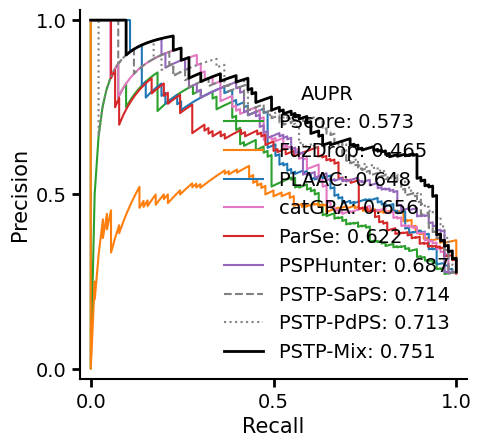

In [3]:

''' 
AUPR
'''
fig, ax = plt.subplots(figsize=(5,4.8))


prec, reca, aupr = compute_prec_reca(ty,pscore_py)
plt.plot(reca,prec, color='tab:green',linewidth=1.5,label=f"PScore: {aupr:.3f}")
prec, reca, aupr = compute_prec_reca(fuzdrop_ty,fuzdrop_py)
plt.plot(reca,prec, color='tab:orange',linewidth=1.5,label=f"FuzDrop: {aupr:.3f}")
prec, reca, aupr = compute_prec_reca(ty,plaac_py)
plt.plot(reca,prec, color='tab:blue',linewidth=1.5,label=f"PLAAC: {aupr:.3f}")
prec, reca, aupr = compute_prec_reca(ty,catgra_py)
plt.plot(reca,prec, color='tab:pink',linewidth=1.5,label=f"catGRA: {aupr:.3f}")
prec, reca, aupr = compute_prec_reca(parse_ty,parse_py)
plt.plot(reca,prec, color='tab:red',linewidth=1.5,label=f"ParSe: {aupr:.3f}")
prec, reca, aupr = compute_prec_reca(ty,hunter_py)
plt.plot(reca,prec, color='tab:purple',linewidth=1.5,label=f"PSPHunter: {aupr:.3f}",)
prec, reca, aupr = compute_prec_reca(ty,scan_saps_py)
plt.plot(reca,prec, color='gray',linewidth=1.5,label=f"PSTP-SaPS: {aupr:.3f}",
         linestyle='--')
prec, reca, aupr = compute_prec_reca(ty,scan_pdps_py)
plt.plot(reca,prec, color='gray',linewidth=1.5,label=f"PSTP-PdPS: {aupr:.3f}",
         linestyle=':')

prec, reca, aupr = compute_prec_reca(ty,scan_mix_py)
plt.plot(reca,prec, color='black',linewidth=2,label=f"PSTP-Mix: {aupr:.3f}",
         )
###############################
legend = plt.legend(loc='lower right',frameon=False,fontsize=14,title='AUPR')
title = legend.get_title()
title.set_position((-10,0))   
title.set_fontsize(14)   
title.set_fontweight('medium')
ax = plt.gca()
ax.spines["top"].set_linewidth(False)
ax.spines["right"].set_linewidth(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.tick_params(axis='both', which='major', width=2,length=6)
# plt.plot([0, 1], [0, 1], 'k--',lw=2,color='silver')
plt.xlim([-0.03, 1.03])
plt.ylim([-0.03, 1.03])
plt.xticks([0,0.5,1],fontsize=14)
plt.yticks([0,0.5,1],fontsize=14)
plt.xlabel('Recall',fontsize=15)
plt.ylabel('Precision',fontsize=15)
# plt.tight_layout()
plt.show()

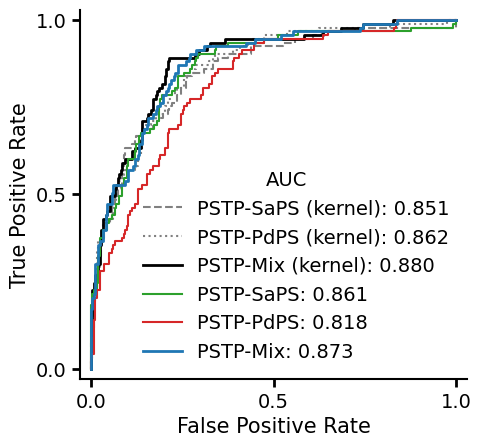

In [4]:

fig, ax = plt.subplots(figsize=(5,4.8))


fpr,tpr,roc_auc = compute_fpr_tpr(ty,scan_saps_py)
plt.plot(fpr, tpr, color='gray',linewidth=1.5,label=f"PSTP-SaPS (kernel): {roc_auc:.3f}",
         linestyle='--')
fpr,tpr,roc_auc = compute_fpr_tpr(ty,scan_pdps_py)
plt.plot(fpr, tpr, color='gray',linewidth=1.5,label=f"PSTP-PdPS (kernel): {roc_auc:.3f}",
         linestyle=':')
fpr,tpr,roc_auc = compute_fpr_tpr(ty,scan_mix_py)
plt.plot(fpr, tpr, color='black',linewidth=2,label=f"PSTP-Mix (kernel): {roc_auc:.3f}",
         )

fpr,tpr,roc_auc = compute_fpr_tpr(ty,scanall_saps_py)
plt.plot(fpr, tpr, color='tab:green',linewidth=1.5,label=f"PSTP-SaPS: {roc_auc:.3f}",)
fpr,tpr,roc_auc = compute_fpr_tpr(ty,scanall_pdps_py)
plt.plot(fpr, tpr, color='tab:red',linewidth=1.5,label=f"PSTP-PdPS: {roc_auc:.3f}",)
fpr,tpr,roc_auc = compute_fpr_tpr(ty,scanall_mix_py)
plt.plot(fpr, tpr, color='tab:blue',linewidth=2,label=f"PSTP-Mix: {roc_auc:.3f}",
         )
###############################
legend = plt.legend(loc='lower right',frameon=False,fontsize=14,title='AUC')
title = legend.get_title()
title.set_position((-10,0))   
title.set_fontsize(14)   
title.set_fontweight('medium')
ax = plt.gca()
ax.spines["top"].set_linewidth(False)
ax.spines["right"].set_linewidth(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.tick_params(axis='both', which='major', width=2,length=6)
# plt.plot([0, 1], [0, 1], 'k--',lw=2,color='silver')
plt.xlim([-0.03, 1.03])
plt.ylim([-0.03, 1.03])
plt.xticks([0,0.5,1],fontsize=14)
plt.yticks([0,0.5,1],fontsize=14)
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
# plt.tight_layout()
plt.show()

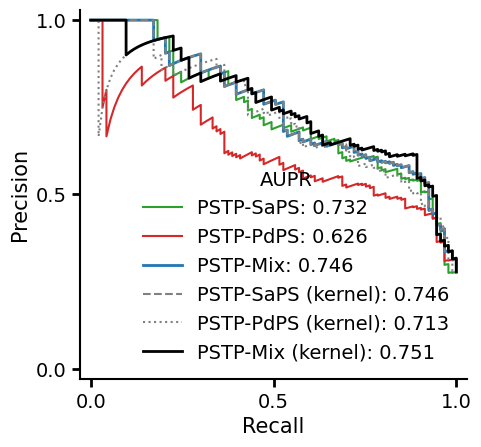

In [5]:

''' 
AUPR
'''
fig, ax = plt.subplots(figsize=(5,4.8))
prec, reca, aupr = compute_prec_reca(ty,scanall_saps_py)
plt.plot(reca,prec, color='tab:green',linewidth=1.5,label=f"PSTP-SaPS: {aupr:.3f}",)
prec, reca, aupr = compute_prec_reca(ty,scanall_pdps_py)
plt.plot(reca,prec, color='tab:red',linewidth=1.5,label=f"PSTP-PdPS: {aupr:.3f}",)
prec, reca, aupr = compute_prec_reca(ty,scanall_mix_py)
plt.plot(reca,prec, color='tab:blue',linewidth=2,label=f"PSTP-Mix: {aupr:.3f}",
         )

plt.plot(reca,prec, color='gray',linewidth=1.5,label=f"PSTP-SaPS (kernel): {aupr:.3f}",
         linestyle='--')
prec, reca, aupr = compute_prec_reca(ty,scan_pdps_py)
plt.plot(reca,prec, color='gray',linewidth=1.5,label=f"PSTP-PdPS (kernel): {aupr:.3f}",
         linestyle=':')

prec, reca, aupr = compute_prec_reca(ty,scan_mix_py)
plt.plot(reca,prec, color='black',linewidth=2,label=f"PSTP-Mix (kernel): {aupr:.3f}",
         )
###############################
legend = plt.legend(loc='lower right',frameon=False,fontsize=14,title='AUPR')
title = legend.get_title()
title.set_position((-10,0))  
title.set_fontsize(14)   
title.set_fontweight('medium')
ax = plt.gca()
ax.spines["top"].set_linewidth(False)
ax.spines["right"].set_linewidth(False)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
plt.tick_params(axis='both', which='major', width=2,length=6)
# plt.plot([0, 1], [0, 1], 'k--',lw=2,color='silver')
plt.xlim([-0.03, 1.03])
plt.ylim([-0.03, 1.03])
plt.xticks([0,0.5,1],fontsize=14)
plt.yticks([0,0.5,1],fontsize=14)
plt.xlabel('Recall',fontsize=15)
plt.ylabel('Precision',fontsize=15)
# plt.tight_layout()
plt.show()